--- Original Scan Stats (15068N) ---
Shape: (512, 512, 706)
Min/Max: 0.00 / 4095.00\n
--- Processed 128x128 Scan Stats (15068N) ---
Shape: (128, 128, 128)
Min/Max: 0.00 / 1.00\n


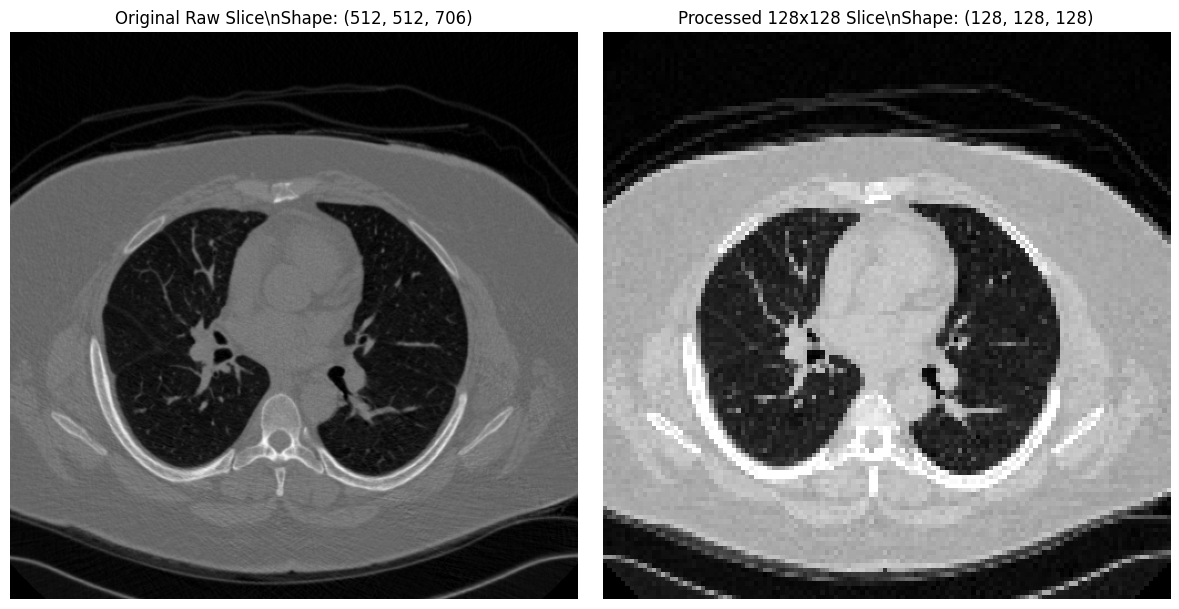

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import zoom

# --- Configuration ---
RAW_DATA_DIR = Path("/mnt/hot/public/COPDGene-1")
PATIENT_ID = "15068N" # Example patient ID
SCAN_TYPE = "INSP"

# --- REVERTED: Target shape for all scans ---
TARGET_SHAPE = (128, 128, 128)

# --- Processing Functions (from preprocess_data.py) ---
def normalize_scan_percentile(scan_data: np.ndarray) -> np.ndarray:
    min_bound = np.percentile(scan_data, 1)
    max_bound = np.percentile(scan_data, 99)
    if max_bound == min_bound:
        return np.zeros(scan_data.shape, dtype=np.float32)
    scan_data = np.clip(scan_data, min_bound, max_bound)
    scan_data = (scan_data - min_bound) / (max_bound - min_bound)
    return scan_data.astype(np.float32)

# --- Load and Process the Scan ---
try:
    raw_path = RAW_DATA_DIR / f"{PATIENT_ID}_{SCAN_TYPE}_image.nii.gz"
    raw_nii = nib.load(raw_path)
    raw_scan_3d = raw_nii.get_fdata()

    # Resize to 128x128x128
    zoom_factors = [t / s for t, s in zip(TARGET_SHAPE, raw_scan_3d.shape)]
    resized_scan_3d = zoom(raw_scan_3d, zoom_factors, order=1)
    
    # Normalize the resized scan
    normalized_128 = normalize_scan_percentile(resized_scan_3d)

    # --- Print Statistics ---
    print(f"--- Original Scan Stats ({PATIENT_ID}) ---")
    print(f"Shape: {raw_scan_3d.shape}")
    print(f"Min/Max: {raw_scan_3d.min():.2f} / {raw_scan_3d.max():.2f}\\n")
    
    print(f"--- Processed 128x128 Scan Stats ({PATIENT_ID}) ---")
    print(f"Shape: {normalized_128.shape}")
    print(f"Min/Max: {normalized_128.min():.2f} / {normalized_128.max():.2f}\\n")

    # --- Visualize the Comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    slice_idx_raw = int(raw_scan_3d.shape[2] * 0.6)
    slice_idx_processed = int(normalized_128.shape[2] * 0.6)

    axes[0].imshow(raw_scan_3d[:, :, slice_idx_raw].T, cmap='gray')
    axes[0].set_title(f"Original Raw Slice\\nShape: {raw_scan_3d.shape}")
    axes[0].axis('off')

    axes[1].imshow(normalized_128[:, :, slice_idx_processed].T, cmap='gray')
    axes[1].set_title(f"Processed 128x128 Slice\\nShape: {normalized_128.shape}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find the file for patient {PATIENT_ID}. Please check the ID and RAW_DATA_DIR path.")